In [1]:
!pip install boto3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 7.1 MB/s eta 0:00:00


In [50]:
import pandas as pd
import boto3
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from statsmodels.tsa.stattools import ccf
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [6]:
AWS_ACCESS_KEY_ID = ''
AWS_SECRET_ACCESS_KEY = ''
BUCKET_NAME = 'ix-iot-data-bucket'
FILE_PREFIX = 'HealthDataCSV/HealthData'

In [7]:
s3 = boto3.client(
    's3',
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY
)


In [8]:
# List all objects in the bucket with the specified prefix
objects = s3.list_objects_v2(Bucket=BUCKET_NAME, Prefix=FILE_PREFIX)

# Initialize an empty list to store dataframes
dfs = []

# Iterate through the objects and read each file into a dataframe
for obj in objects.get('Contents', []):
    key = obj['Key']
    if not key.endswith('/'):  # Exclude directory prefixes
        try:
            file_obj = s3.get_object(Bucket=BUCKET_NAME, Key=key)
            df = pd.read_csv(file_obj['Body'])  # Adjust the read function if files are not csv
            dfs.append(df)
        except Exception as e:
            print(f"Error reading file {key}: {e}")

# Concatenate all dataframes into a single dataframe
if dfs:
    df = pd.concat(dfs, ignore_index=True)
    print(df.head()) # Optional: display the first few rows
else:
    print("No files found in the specified bucket and path.")

         Type             StartDate               EndDate  Value Unit
0  Heart Rate  2024-12-03T19:41:06Z  2024-12-03T19:41:06Z  117.0  bpm
1  Heart Rate  2024-12-03T19:41:10Z  2024-12-03T19:41:10Z  116.0  bpm
2  Heart Rate  2024-12-03T19:41:12Z  2024-12-03T19:41:12Z  116.0  bpm
3  Heart Rate  2024-12-03T19:41:19Z  2024-12-03T19:41:19Z  115.0  bpm
4  Heart Rate  2024-12-03T19:41:22Z  2024-12-03T19:41:22Z  114.0  bpm


In [9]:
# Convert StartDate and EndDate to datetime, handling empty EndDates
df['StartDate'] = pd.to_datetime(df['StartDate'], errors='coerce', utc=True)
df['EndDate'] = pd.to_datetime(df['EndDate'], errors='coerce', utc=True)

In [10]:
df.dtypes

,0
Type,object
StartDate,"datetime64[ns, UTC]"
EndDate,"datetime64[ns, UTC]"
Value,float64
Unit,object


In [11]:
df['Type'].value_counts()

,count
Type,
Heart Rate,8489
Blood Glucose,1858
Sleep,211


In [12]:
sleep_data = df[df['Type'] == 'Sleep'].copy()
glucose_data = df[df['Type'] == 'Blood Glucose'].copy()
heart_data = df[df['Type'] == 'Heart Rate'].copy()

In [13]:
sleep_state_map = {
    0: "In Bed",
    1: "Asleep Unspecified",
    2: "Awake",
    3: "Asleep",
    4: "Asleep Deep",
    5: "Asleep REM"
}

sleep_data['SleepState'] = sleep_data['Value'].map(sleep_state_map)

In [14]:
sleep_data['SleepState'].value_counts()

,count
SleepState,
Asleep,103
Awake,48
Asleep REM,32
Asleep Deep,28


In [15]:
sleep_data['Duration'] = sleep_data['EndDate'] - sleep_data['StartDate']

In [16]:
sleep_data.head()

,Type,StartDate,EndDate,Value,Unit,SleepState,Duration
436,Sleep,2024-12-04 23:00:18+00:00,2024-12-04 23:22:18+00:00,3.0,Sleep Analysis,Asleep,0 days 00:22:00
437,Sleep,2024-12-04 23:22:18+00:00,2024-12-04 23:23:18+00:00,2.0,Sleep Analysis,Awake,0 days 00:01:00
438,Sleep,2024-12-04 23:23:18+00:00,2024-12-04 23:26:18+00:00,3.0,Sleep Analysis,Asleep,0 days 00:03:00
439,Sleep,2024-12-04 23:26:18+00:00,2024-12-04 23:27:18+00:00,2.0,Sleep Analysis,Awake,0 days 00:01:00
440,Sleep,2024-12-04 23:27:18+00:00,2024-12-04 23:36:18+00:00,3.0,Sleep Analysis,Asleep,0 days 00:09:00


In [17]:
sleep_data['Date'] = sleep_data['StartDate'].dt.date

In [18]:
daily_sleep = sleep_data.groupby('Date')['Duration'].sum()
daily_sleep = daily_sleep.dt.total_seconds() / 3600

In [ ]:
print(glucose_data['Value'].describe())

count    1858.000000
mean       96.583423
std        17.184538
min        58.000000
25%        84.000000
50%        92.000000
75%       106.000000
max       171.000000
Name: Value, dtype: float64


In [19]:
glucose_data['Date'] = glucose_data['StartDate'].dt.date
daily_glucose_mean = glucose_data.groupby('Date')['Value'].mean()
daily_glucose_max = glucose_data.groupby('Date')['Value'].max()

In [20]:
heart_data['Date'] = heart_data['StartDate'].dt.date
daily_hr_mean = heart_data.groupby('Date')['Value'].mean()
daily_hr_min = heart_data.groupby('Date')['Value'].min()
daily_hr_max = heart_data.groupby('Date')['Value'].max()

In [21]:
daily_metrics = pd.DataFrame({
    'AvgGlucose': daily_glucose_mean,
    'MaxGlucose': daily_glucose_max,
    'TotalSleepHours': daily_sleep,
    'AvgHR': daily_hr_mean,
    'MinHR': daily_hr_min,
    'MaxHR': daily_hr_max
})

In [ ]:
daily_metrics

,AvgGlucose,MaxGlucose,TotalSleepHours,AvgHR,MinHR,MaxHR
Date,,,,,,
2024-11-28,NaN,NaN,NaN,107.334842,68.0,133.0
2024-11-29,NaN,NaN,NaN,106.938985,45.0,136.0
2024-11-30,NaN,NaN,NaN,110.704853,67.0,144.0
2024-12-02,NaN,NaN,NaN,99.874744,51.0,138.0
2024-12-03,NaN,NaN,NaN,100.083157,63.0,131.0
2024-12-04,120.000000,138.0,1.341667,99.000800,58.0,131.0
2024-12-05,125.455882,171.0,6.616667,88.516048,59.0,148.0
2024-12-06,96.923404,134.0,7.083333,104.494061,59.0,146.0
2024-12-07,91.660000,117.0,6.641667,82.146822,54.0,111.0


In [22]:
correlation = daily_metrics.corr()
print("Correlation matrix:\n", correlation)

Correlation matrix:
                  AvgGlucose  MaxGlucose  TotalSleepHours     AvgHR     MinHR  \
AvgGlucose         1.000000    0.857055        -0.606611 -0.093913  0.359878   
MaxGlucose         0.857055    1.000000        -0.185424 -0.175255  0.301746   
TotalSleepHours   -0.606611   -0.185424         1.000000 -0.251841 -0.096534   
AvgHR             -0.093913   -0.175255        -0.251841  1.000000 -0.118183   
MinHR              0.359878    0.301746        -0.096534 -0.118183  1.000000   
MaxHR              0.020255    0.037582         0.087811  0.697124 -0.266409   

                    MaxHR  
AvgGlucose       0.020255  
MaxGlucose       0.037582  
TotalSleepHours  0.087811  
AvgHR            0.697124  
MinHR           -0.266409  
MaxHR            1.000000  


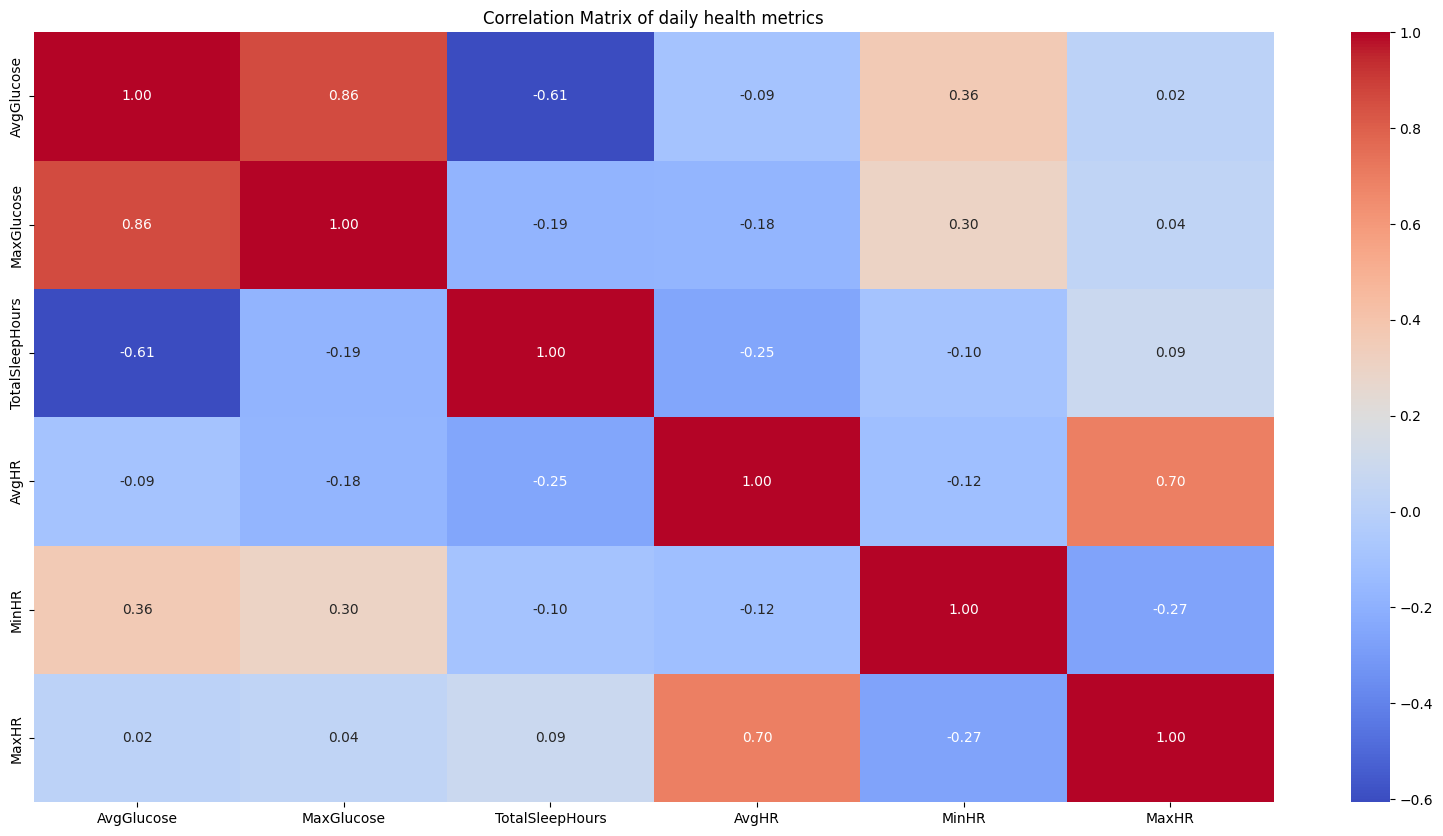

In [23]:
# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of daily health metrics')
plt.show()

In [29]:
df.head()

,Type,StartDate,EndDate,Value,Unit
0,Heart Rate,2024-12-03 19:41:06+00:00,2024-12-03 19:41:06+00:00,117.0,bpm
1,Heart Rate,2024-12-03 19:41:10+00:00,2024-12-03 19:41:10+00:00,116.0,bpm
2,Heart Rate,2024-12-03 19:41:12+00:00,2024-12-03 19:41:12+00:00,116.0,bpm
3,Heart Rate,2024-12-03 19:41:19+00:00,2024-12-03 19:41:19+00:00,115.0,bpm
4,Heart Rate,2024-12-03 19:41:22+00:00,2024-12-03 19:41:22+00:00,114.0,bpm


 Sleep-Glucose Relationship Analysis

In [30]:
# Filter for meaningful sleep states
asleep_states = ["Asleep", "Asleep Deep", "Asleep REM"]
daily_sleep = sleep_data[sleep_data['SleepState'].isin(asleep_states)]
daily_sleep_summary = daily_sleep.groupby(daily_sleep['StartDate'].dt.date)['Duration'].sum().reset_index()
daily_sleep_summary.columns = ['Date', 'TotalSleepHours']


In [32]:
# Preprocess glucose data
daily_glucose_summary = glucose_data.groupby('Date')['Value'].mean().reset_index()
daily_glucose_summary.columns = ['Date', 'AvgGlucose']


In [33]:
# Merge sleep and glucose data
merged_data = pd.merge(daily_glucose_summary, daily_sleep_summary, on='Date', how='inner')

In [34]:
# Lead-lag analysis
max_lag = 7  # Maximum lag (days)
lags = range(-max_lag, max_lag + 1)
correlations = []

In [36]:
for lag in lags:
    shifted_data = merged_data.copy()
    shifted_data['LaggedGlucose'] = shifted_data['AvgGlucose'].shift(lag)
    correlation = shifted_data[['LaggedGlucose', 'TotalSleepHours']].corr().iloc[0, 1]
    correlations.append(correlation)

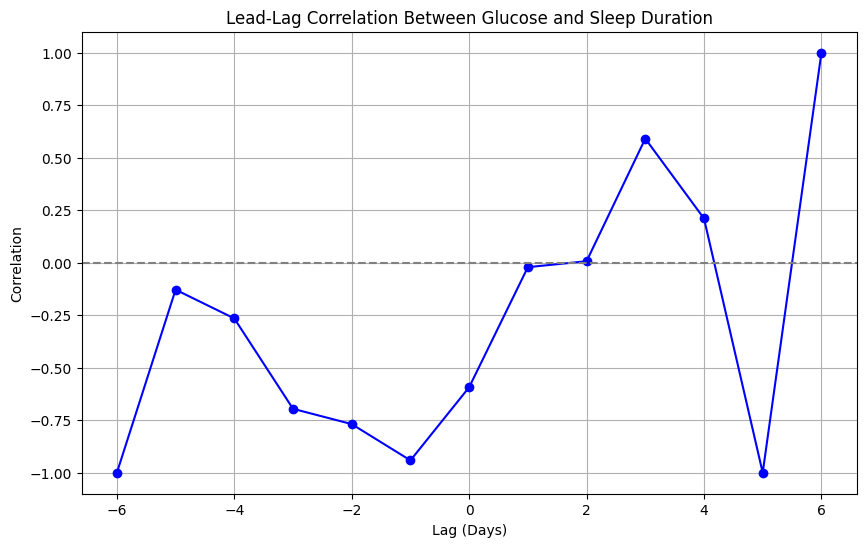

In [37]:
# Plot lead-lag correlations
plt.figure(figsize=(10, 6))
plt.plot(lags, correlations, marker='o', linestyle='-', color='b')
plt.axhline(y=0, color='gray', linestyle='--')
plt.title('Lead-Lag Correlation Between Glucose and Sleep Duration')
plt.xlabel('Lag (Days)')
plt.ylabel('Correlation')
plt.grid()
plt.show()

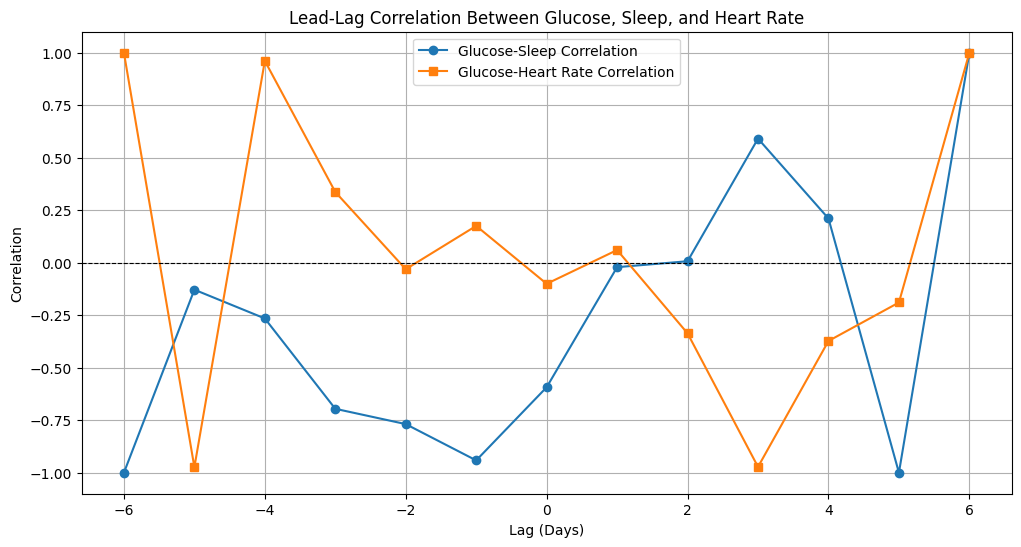

In [154]:
# Filter for meaningful sleep states
asleep_states = ["Asleep", "Asleep Deep", "Asleep REM"]
daily_sleep = sleep_data[sleep_data['SleepState'].isin(asleep_states)]
daily_sleep_summary = daily_sleep.groupby(daily_sleep['StartDate'].dt.date)['Duration'].sum().reset_index()
daily_sleep_summary.columns = ['Date', 'TotalSleepHours']

# Preprocess glucose data
daily_glucose_summary = glucose_data.groupby('Date')['Value'].mean().reset_index()
daily_glucose_summary.columns = ['Date', 'AvgGlucose']

# Preprocess heart rate data
daily_heart_rate_summary = heart_data.groupby(heart_data['StartDate'].dt.date)['Value'].mean().reset_index()
daily_heart_rate_summary.columns = ['Date', 'AvgHeartRate']

# Merge all datasets
merged_data = pd.merge(daily_glucose_summary, daily_sleep_summary, on='Date', how='inner')
merged_data = pd.merge(merged_data, daily_heart_rate_summary, on='Date', how='inner')

# Lead-lag analysis for glucose and sleep
max_lag = 7  # Maximum lag (days)
lags = range(-max_lag, max_lag + 1)
glucose_sleep_correlations = []

for lag in lags:
    shifted_data = merged_data.copy()
    shifted_data['LaggedGlucose'] = shifted_data['AvgGlucose'].shift(lag)
    correlation = shifted_data[['LaggedGlucose', 'TotalSleepHours']].corr().iloc[0, 1]
    glucose_sleep_correlations.append(correlation)

# Lead-lag analysis for glucose and heart rate
glucose_hr_correlations = []

for lag in lags:
    shifted_data = merged_data.copy()
    shifted_data['LaggedGlucose'] = shifted_data['AvgGlucose'].shift(lag)
    correlation = shifted_data[['LaggedGlucose', 'AvgHeartRate']].corr().iloc[0, 1]
    glucose_hr_correlations.append(correlation)

# Plot correlations
plt.figure(figsize=(12, 6))
plt.plot(lags, glucose_sleep_correlations, label='Glucose-Sleep Correlation', marker='o')
plt.plot(lags, glucose_hr_correlations, label='Glucose-Heart Rate Correlation', marker='s')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title('Lead-Lag Correlation Between Glucose, Sleep, and Heart Rate')
plt.xlabel('Lag (Days)')
plt.ylabel('Correlation')
plt.legend()
plt.grid(True)
plt.show()


 Clustering Glucose Patterns

In [59]:
# Load CGM data
cgm_data = glucose_data.copy()

In [60]:
#  target glucose range
TIR_LOWER = 70  # mg/dL
TIR_UPPER = 180  # mg/dL

# Time in Range (TIR)
total_readings = len(cgm_data)
in_range_readings = cgm_data[(cgm_data['Value'] >= TIR_LOWER) & (cgm_data['Value'] <= TIR_UPPER)]
tir_percentage = (len(in_range_readings) / total_readings) * 100

In [61]:
# Glucose Variability
mean_glucose = cgm_data['Value'].mean()
std_dev_glucose = cgm_data['Value'].std()
cv_glucose = (std_dev_glucose / mean_glucose) * 100  # Coefficient of Variation
mad_glucose = (cgm_data['Value'] - cgm_data['Value'].mean()).abs().mean()   # Mean Absolute Deviation
# Predicted HbA1c
predicted_hba1c = (mean_glucose + 46.7) / 28.7

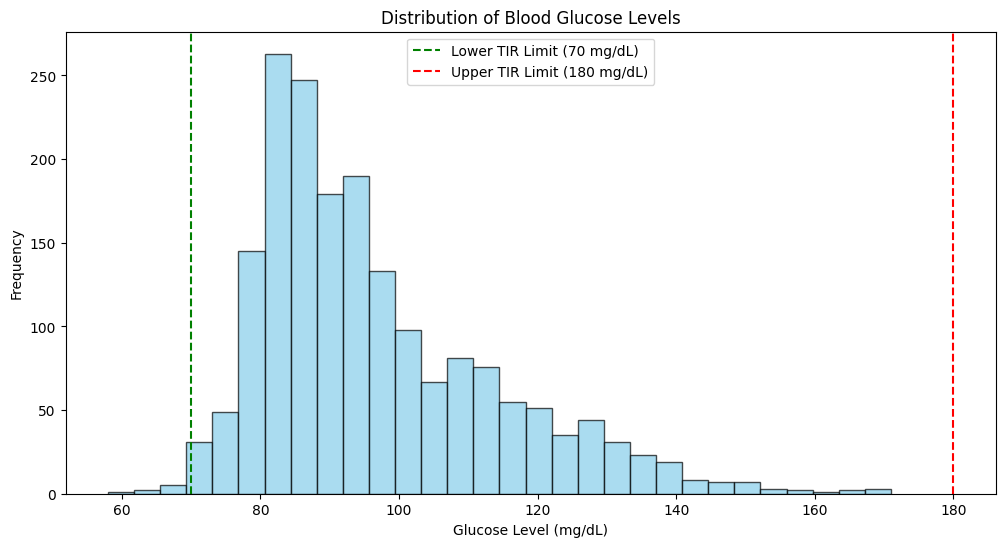

In [62]:
# Plot TIR
plt.figure(figsize=(12, 6))
plt.hist(cgm_data['Value'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(TIR_LOWER, color='green', linestyle='--', label='Lower TIR Limit (70 mg/dL)')
plt.axvline(TIR_UPPER, color='red', linestyle='--', label='Upper TIR Limit (180 mg/dL)')
plt.title('Distribution of Blood Glucose Levels')
plt.xlabel('Glucose Level (mg/dL)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [63]:
# Print the results
print("CGM Analysis Results:")
print(f"Time in Range (70-180 mg/dL): {tir_percentage:.2f}%")
print(f"Mean Glucose: {mean_glucose:.2f} mg/dL")
print(f"Standard Deviation of Glucose: {std_dev_glucose:.2f} mg/dL")
print(f"Coefficient of Variation (CV): {cv_glucose:.2f}%")
print(f"Mean Absolute Deviation (MAD): {mad_glucose:.2f} mg/dL")
print(f"Predicted HbA1c: {predicted_hba1c:.2f}%")

CGM Analysis Results:
Time in Range (70-180 mg/dL): 99.57%
Mean Glucose: 96.58 mg/dL
Standard Deviation of Glucose: 17.18 mg/dL
Coefficient of Variation (CV): 17.79%
Mean Absolute Deviation (MAD): 13.53 mg/dL
Predicted HbA1c: 4.99%


In [64]:
# Feature Engineering
cgm_data['Hour'] = cgm_data['StartDate'].dt.hour
cgm_data['DayOfWeek'] = cgm_data['StartDate'].dt.dayofweek
cgm_data['IsMorning'] = cgm_data['Hour'].apply(lambda x: 1 if 5 <= x <= 11 else 0)  # Morning: 5 AM - 11 AM

In [65]:
# Aggregate hourly glucose values
cgm_hourly = cgm_data.groupby(['Hour']).agg({'Value': ['mean', 'std']}).reset_index()
cgm_hourly.columns = ['Hour', 'MeanGlucose', 'StdDevGlucose']


In [66]:
# Prepare data for clustering
features = cgm_hourly[['MeanGlucose', 'StdDevGlucose']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [67]:
# Determine optimal number of clusters using the Elbow Method
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

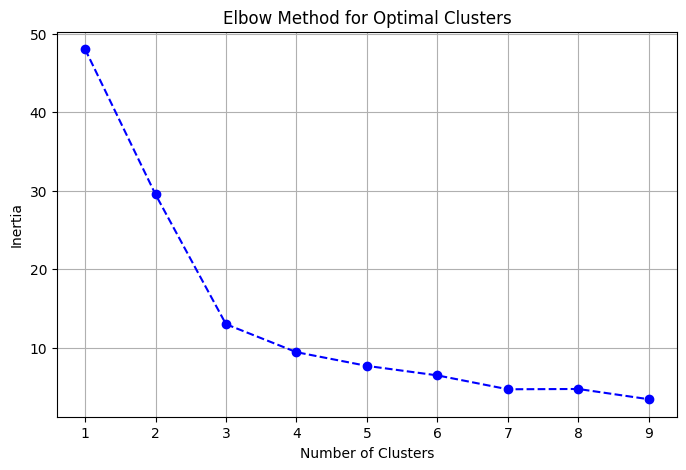

In [68]:
# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 10), inertia, marker='o', linestyle='--', color='b')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid()
plt.show()

In [69]:
# Fit K-means with optimal clusters
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
cgm_hourly['Cluster'] = kmeans.fit_predict(scaled_features)


In [70]:
cgm_hourly.head()

,Hour,MeanGlucose,StdDevGlucose,Cluster
0,0,108.010309,14.468713,1
1,1,101.208333,12.356048,1
2,2,98.104167,14.509873,1
3,3,91.197917,8.488531,2
4,4,90.450549,10.841549,2


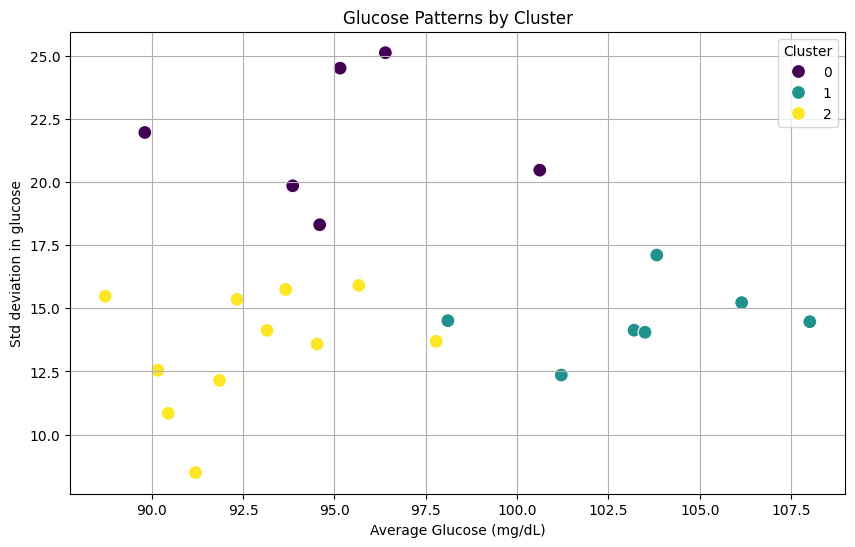

In [71]:
# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=cgm_hourly['MeanGlucose'],
    y=cgm_hourly['StdDevGlucose'],
    hue=cgm_hourly['Cluster'],
    palette='viridis',
    s=100
)
plt.title('Glucose Patterns by Cluster')
plt.xlabel('Average Glucose (mg/dL)')
plt.ylabel('Std deviation in glucose')
plt.legend(title='Cluster')
plt.grid()
plt.show()

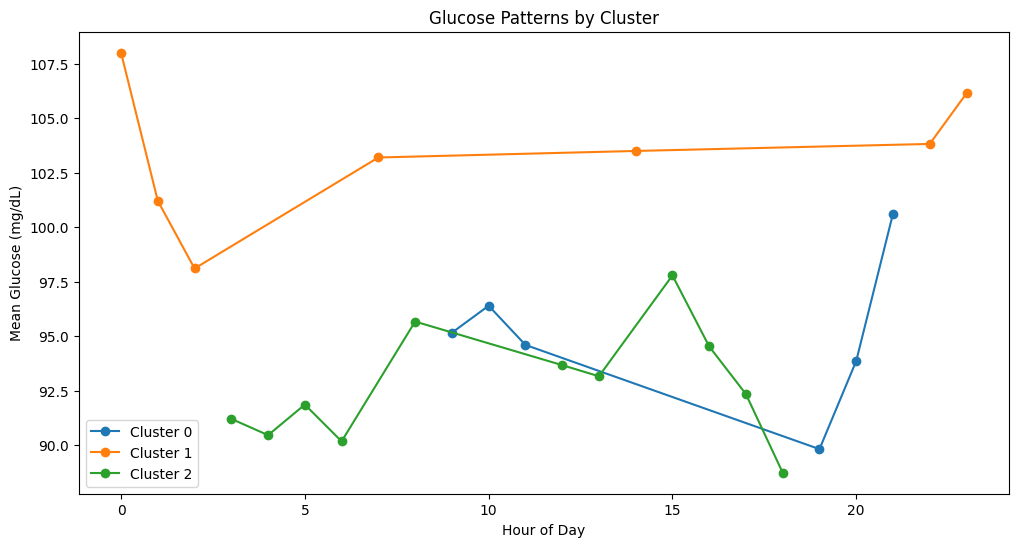

In [72]:
# Visualize Clusters
plt.figure(figsize=(12, 6))
for cluster in range(optimal_clusters):
    cluster_data = cgm_hourly[cgm_hourly['Cluster'] == cluster]
    plt.plot(cluster_data['Hour'], cluster_data['MeanGlucose'], marker='o', label=f'Cluster {cluster}')
plt.title('Glucose Patterns by Cluster')
plt.xlabel('Hour of Day')
plt.ylabel('Mean Glucose (mg/dL)')
plt.legend()
plt.show()

In [73]:
# Cluster Characteristics
cluster_summary = cgm_hourly.groupby('Cluster').agg({
    'MeanGlucose': ['mean', 'std'],
    'StdDevGlucose': ['mean', 'std']
}).reset_index()

print("Cluster Summary:")
print(cluster_summary)

Cluster Summary:
  Cluster MeanGlucose           StdDevGlucose          
                 mean       std          mean       std
0       0   95.071276  3.519032     21.702655  2.686774
1       1  103.427266  3.211097     14.549759  1.428515
2       2   92.684256  2.636378     13.444994  2.312843


In [132]:
# Ensure datetime formats are consistent
asleep_states = ["Asleep", "Asleep Deep", "Asleep REM"]

sleep_data = sleep_data[sleep_data['SleepState'].isin(asleep_states)]


In [133]:
# Aggregate sleep duration by day
sleep_data['Duration'] = (sleep_data['EndDate'] - sleep_data['StartDate']).dt.total_seconds() / 3600  # Hours
daily_sleep = sleep_data.groupby(sleep_data['StartDate'].dt.date)['Duration'].sum().reset_index()
daily_sleep.columns = ['Date', 'TotalSleepHours']

<ipython-input-133-81ad60181357>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sleep_data['Duration'] = (sleep_data['EndDate'] - sleep_data['StartDate']).dt.total_seconds() / 3600  # Hours


In [135]:
# Aggregate heart rate by day
daily_heart_rate = heart_data.groupby(heart_data['StartDate'].dt.date)['Value'].mean().reset_index()
daily_heart_rate.columns = ['Date', 'AvgHR']

In [136]:
# Add hourly glucose clusters to original CGM data
cgm_data['Hour'] = cgm_data['StartDate'].dt.hour
cgm_data = pd.merge(cgm_data, cgm_hourly[['Hour', 'Cluster']], on='Hour', how='left')

In [137]:
# Aggregate glucose clusters by day
daily_glucose_clusters = cgm_data.groupby([cgm_data['StartDate'].dt.date, 'Cluster'])['Value'].mean().unstack(fill_value=0).reset_index()
daily_glucose_clusters.columns = ['Date', 'Cluster0', 'Cluster1', 'Cluster2']


In [138]:
# Merge daily data
merged_data = pd.merge(daily_glucose_clusters, daily_sleep, on='Date', how='left')
merged_data = pd.merge(merged_data, daily_heart_rate, on='Date', how='left')

In [139]:
# Fill missing values
merged_data.fillna(0, inplace=True)


In [142]:
merged_data= merged_data.drop(columns=['Date'])

In [143]:
# Correlation analysis
correlation_matrix = merged_data.corr()

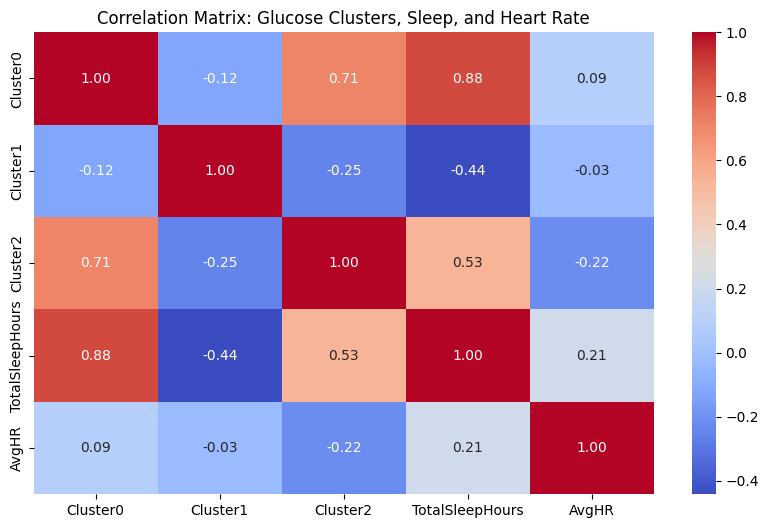

In [144]:
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix: Glucose Clusters, Sleep, and Heart Rate')
plt.show()


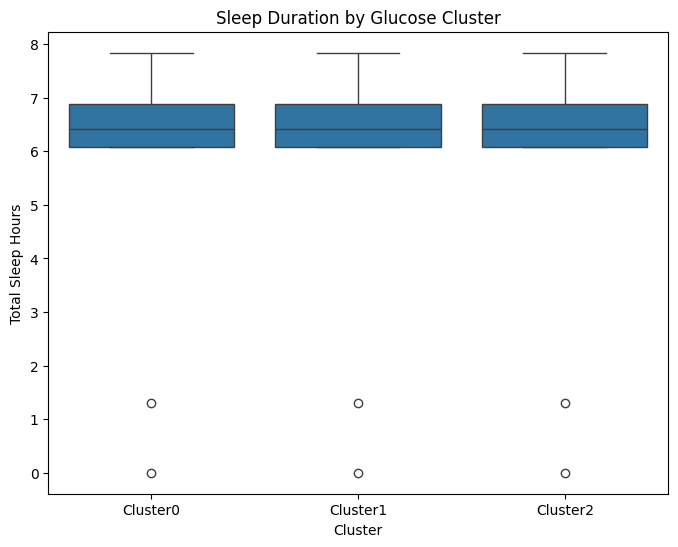

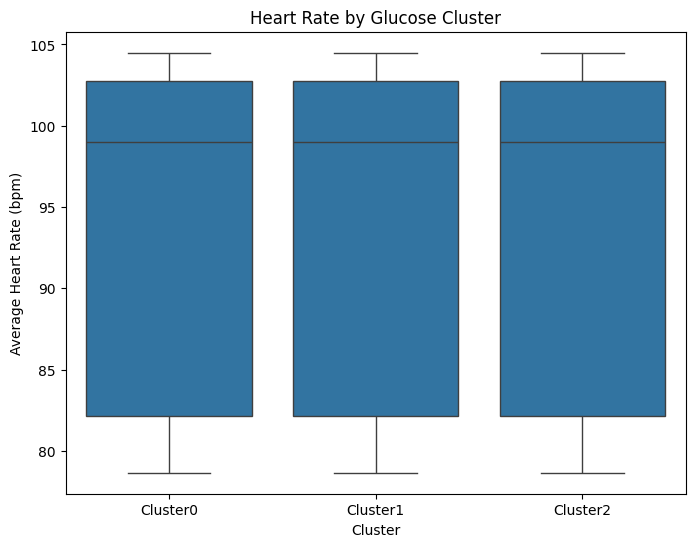

In [148]:
# Melt the cluster data for visualization
cluster_columns = ['Cluster0', 'Cluster1', 'Cluster2']
melted_data = merged_data.melt(
    id_vars=['TotalSleepHours', 'AvgHR'],
    value_vars=cluster_columns,
    var_name='Cluster',
    value_name='GlucoseValue'
)

# Ensure clusters are categorical
melted_data['Cluster'] = melted_data['Cluster'].astype('category')

# Boxplot: Total Sleep Hours by Cluster
plt.figure(figsize=(8, 6))
sns.boxplot(x='Cluster', y='TotalSleepHours', data=melted_data)
plt.title('Sleep Duration by Glucose Cluster')
plt.xlabel('Cluster')
plt.ylabel('Total Sleep Hours')
plt.show()

# Boxplot: Average Heart Rate by Cluster
plt.figure(figsize=(8, 6))
sns.boxplot(x='Cluster', y='AvgHR', data=melted_data)
plt.title('Heart Rate by Glucose Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Heart Rate (bpm)')
plt.show()

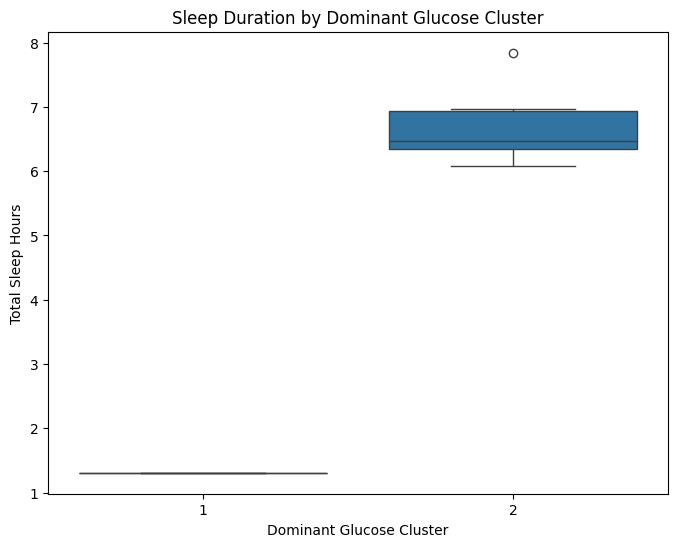

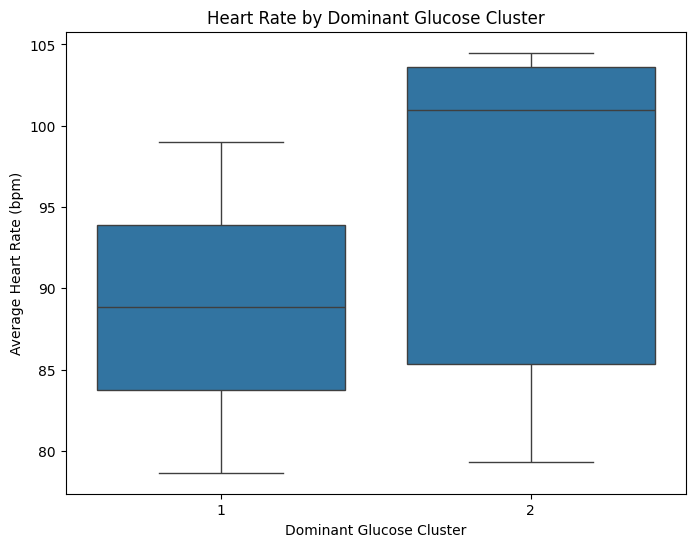

In [150]:
# Aggregate glucose clusters to daily dominant cluster
daily_glucose_clusters = cgm_data.groupby([cgm_data['StartDate'].dt.date, 'Cluster'])['Value'].count().unstack(fill_value=0).reset_index()
daily_glucose_clusters['DominantCluster'] = daily_glucose_clusters[[0, 1, 2]].idxmax(axis=1)
daily_glucose_clusters = daily_glucose_clusters[['StartDate', 'DominantCluster']]
daily_glucose_clusters.columns = ['Date', 'DominantCluster']

# Merge dominant cluster with sleep and heart rate data
merged_data = pd.merge(daily_glucose_clusters, daily_sleep, on='Date', how='left')
merged_data = pd.merge(merged_data, daily_heart_rate, on='Date', how='left')

# Boxplot: Sleep by Dominant Cluster
plt.figure(figsize=(8, 6))
sns.boxplot(x='DominantCluster', y='TotalSleepHours', data=merged_data)
plt.title('Sleep Duration by Dominant Glucose Cluster')
plt.xlabel('Dominant Glucose Cluster')
plt.ylabel('Total Sleep Hours')
plt.show()

# Boxplot: Heart Rate by Dominant Cluster
plt.figure(figsize=(8, 6))
sns.boxplot(x='DominantCluster', y='AvgHR', data=merged_data)
plt.title('Heart Rate by Dominant Glucose Cluster')
plt.xlabel('Dominant Glucose Cluster')
plt.ylabel('Average Heart Rate (bpm)')
plt.show()


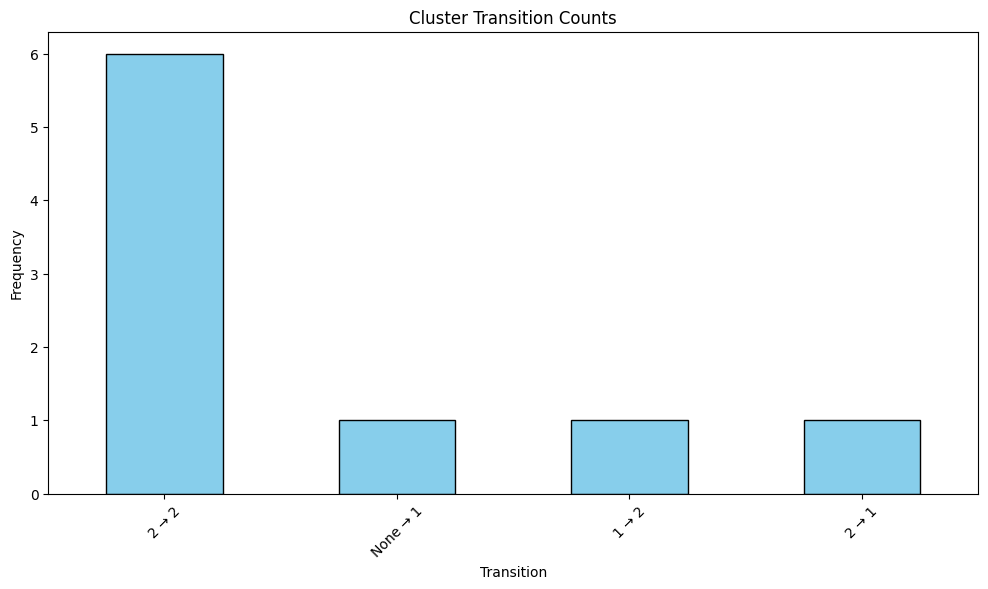

Transition Metrics (Contextual Data):
  Transition  TotalSleepHours      AvgHR
0      1 → 2         6.416667  88.516048
1      2 → 1              NaN  78.651954
2      2 → 2         6.752778  95.679122
3   None → 1         1.308333  99.000800


<ipython-input-151-680bfa138a93>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Transition', y='TotalSleepHours', data=transition_metrics, palette='coolwarm')


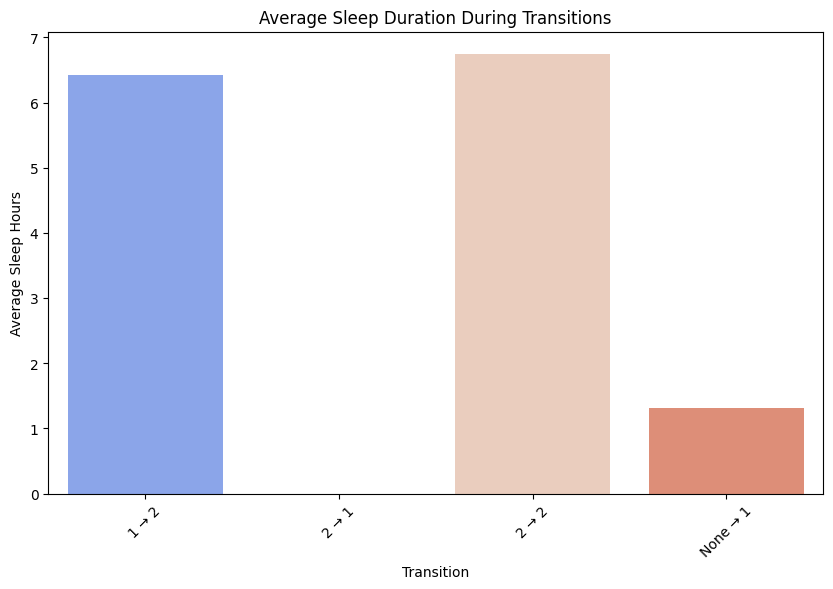

<ipython-input-151-680bfa138a93>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Transition', y='AvgHR', data=transition_metrics, palette='coolwarm')


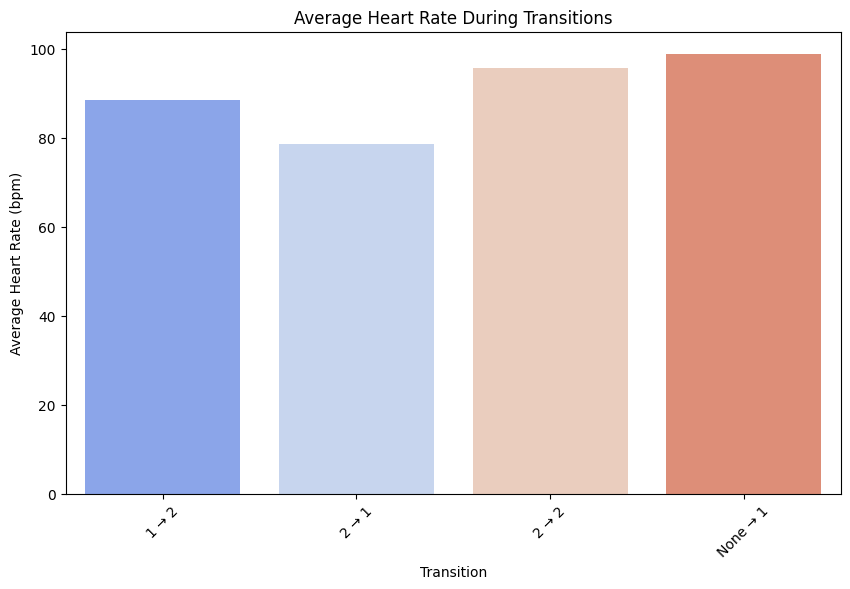

In [151]:
# Add previous cluster column to track transitions
merged_data['PrevCluster'] = merged_data['DominantCluster'].shift(1)

# Create a transition column
merged_data['Transition'] = merged_data['PrevCluster'].astype(str) + " → " + merged_data['DominantCluster'].astype(str)

# Count transitions
transition_counts = merged_data['Transition'].value_counts()

# Visualize transition frequencies
plt.figure(figsize=(12, 6))
transition_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Cluster Transition Counts')
plt.xlabel('Transition')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# Analyze contextual metrics (Sleep and HR) during transitions
transition_metrics = merged_data.groupby('Transition').agg({
    'TotalSleepHours': 'mean',
    'AvgHR': 'mean'
}).reset_index()

# Display transition metrics
print("Transition Metrics (Contextual Data):")
print(transition_metrics)

# Visualize sleep duration during transitions
plt.figure(figsize=(10, 6))
sns.barplot(x='Transition', y='TotalSleepHours', data=transition_metrics, palette='coolwarm')
plt.title('Average Sleep Duration During Transitions')
plt.xlabel('Transition')
plt.ylabel('Average Sleep Hours')
plt.xticks(rotation=45)
plt.show()

# Visualize heart rate during transitions
plt.figure(figsize=(10, 6))
sns.barplot(x='Transition', y='AvgHR', data=transition_metrics, palette='coolwarm')
plt.title('Average Heart Rate During Transitions')
plt.xlabel('Transition')
plt.ylabel('Average Heart Rate (bpm)')
plt.xticks(rotation=45)
plt.show()
